In [160]:
import requests
import numpy as np
import pandas as pd
import json
from bs4 import BeautifulSoup

# 0. 프로젝트 개요

### 0-1. 프로젝트 주제 선정 : 축구 온라인 게임의 축구선수 포지션에 따른 능력치 차이를 분석하고 포지션 및 overall(총능력치) 예측하기

### 0-2. 데이터
   * 축구 온라인 게임 : 피파온라인4 (넥슨), http://fifaonline4.nexon.com/main/index
   * 축구선수 능력치 데이터 (출처 : http://fifaonline4.inven.co.kr/dataninfo/player/) : 피파온라인4의 축구선수 능력치를 모아놓은 사이트 크롤링
      - 각 포지션별 상위 500 명씩 (총 2000명)
      - 축구선수이름 포함 게임에서 표현된 각 능력치가 변수

# 1. 데이터 수집

In [161]:
# 각 포지션별 상위 500명이 노출되어있는 주소 크롤링
# 위 url 부터 공격수, 미드필더, 수비수, 골키퍼
st_url = 'http://fifaonline4.inven.co.kr/dataninfo/player/?mode=getList&season=&position=26%2C22%2C24%2C28&abilityKey1=&abilityVal1=&abilityKey2=&abilityVal2=&abilityKey3=&abilityVal3=&abilityKey4=&abilityVal4=&abilityKey5=&abilityVal5=&abilityKey6=&abilityVal6=&ovrKey=overallrating&ovrValUp=&ovrValDown=&salaryUp=&salaryDown=&trait1=&trait2=&traitNot1=&traitNot2=&birthUp=&birthDown=&heightUp=&heightDown=&league=&weightUp=&weightDown=&bodytype=&nation=&club=&skillmoves=&team=&team2=&mainfoot=&weakfoot=&searchword='
mf_url = 'http://fifaonline4.inven.co.kr/dataninfo/player/?mode=getList&season=&position=15%2C19%2C11%2C17%2C13&abilityKey1=&abilityVal1=&abilityKey2=&abilityVal2=&abilityKey3=&abilityVal3=&abilityKey4=&abilityVal4=&abilityKey5=&abilityVal5=&abilityKey6=&abilityVal6=&ovrKey=overallrating&ovrValUp=&ovrValDown=&salaryUp=&salaryDown=&trait1=&trait2=&traitNot1=&traitNot2=&birthUp=&birthDown=&heightUp=&heightDown=&league=&weightUp=&weightDown=&bodytype=&nation=&club=&skillmoves=&team=&team2=&mainfoot=&weakfoot=&searchword='
df_url = 'http://fifaonline4.inven.co.kr/dataninfo/player/?mode=getList&season=&position=6%2C4%2C8%2C3%2C9&abilityKey1=&abilityVal1=&abilityKey2=&abilityVal2=&abilityKey3=&abilityVal3=&abilityKey4=&abilityVal4=&abilityKey5=&abilityVal5=&abilityKey6=&abilityVal6=&ovrKey=overallrating&ovrValUp=&ovrValDown=&salaryUp=&salaryDown=&trait1=&trait2=&traitNot1=&traitNot2=&birthUp=&birthDown=&heightUp=&heightDown=&league=&weightUp=&weightDown=&bodytype=&nation=&club=&skillmoves=&team=&team2=&mainfoot=&weakfoot=&searchword='
gk_url = 'http://fifaonline4.inven.co.kr/dataninfo/player/?mode=getList&season=&position=1&abilityKey1=&abilityVal1=&abilityKey2=&abilityVal2=&abilityKey3=&abilityVal3=&abilityKey4=&abilityVal4=&abilityKey5=&abilityVal5=&abilityKey6=&abilityVal6=&ovrKey=overallrating&ovrValUp=&ovrValDown=&salaryUp=&salaryDown=&trait1=&trait2=&traitNot1=&traitNot2=&birthUp=&birthDown=&heightUp=&heightDown=&league=&weightUp=&weightDown=&bodytype=&nation=&club=&skillmoves=&team=&team2=&mainfoot=&weakfoot=&searchword='

In [162]:
def getItems(url):
    # 헤더값
    header = {
    'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.87 Safari/537.36'
    }
    
    # 파싱
    response = requests.get(url, headers = header)
    soup = BeautifulSoup(response.text, 'html.parser')
    found_items = soup.select('tbody > tr > td.info')
    
    content_list = []
    for item in found_items:
        name = item.select_one('td.info > div.fifa4 > button')['data-playershortname'] # player 이름
        content = item.select_one('td.info > input') # player 의 정보가 담긴 raw_content

        content = 'data-acceleration' + str(content).split('acceleration')[1] # acceleration 앞은 필요없는 정보들

        value  = [name, content]
        content_list.append(value)
    return content_list

In [163]:
def getDf(url):
    df_temp = pd.DataFrame(getItems(url), columns = ['name', 'content'])
    
    name_list = [] # player 이름 저장
    for i in range(len(df_temp)):
        name = df_temp.iloc[i,0]
        name_list.append(name)
        
        
    ab_list = []
    pl_list = []
    for i in range(len(df_temp)):
        name = df_temp.iloc[i,0]
        for q in range(len(df_temp.iloc[i,1].split(' '))):
            try:
                ability = int(df_temp.iloc[i,1].split(' ')[q].split('=')[1].split('"')[1])
            except:
                ability = 0
            ab_list.append(ability)
        pl_list.append(ab_list)
        ab_list = []
        
        
    columns = []
    column = df_temp.iloc[1,1].split(' ')
    for c in column:
        value = c.split('=')[0]
        try:
            value = value.split('-')[1]
        except:
            value = value
        columns.append(value)
        
        
    df = pd.DataFrame(pl_list, columns = columns)
    df['name'] = name_list
    
    return df
    

In [164]:
df_st = getDf(st_url)
df_mf = getDf(mf_url)
df_df = getDf(df_url)
df_gk = getDf(gk_url)

In [398]:
df_st.columns

Index(['acceleration', 'aggression', 'agility', 'balance', 'ballcontrol',
       'composure', 'crossing', 'curve', 'dribbling', 'finishing',
       'freekickaccuracy', 'gkdiving', 'gkhandling', 'gkkicking',
       'gkpositioning', 'gkreflexes', 'groupcode', 'headingaccuracy', 'height',
       'interceptions', 'jumping', 'longpassing', 'longshots', 'marking',
       'overallrating', 'penalties', 'playercode', 'positioning', 'postat1',
       'postat2', 'postat3', 'postat4', 'reactions', 'salary', 'shortpassing',
       'shotpower', 'skillmoves', 'slidingtackle', 'sprintspeed', 'stamina',
       'standingtackle', 'strength', 'vision', 'volleys', 'weight', 'name',
       'type'],
      dtype='object')

In [166]:
# 각 포지션별 groupcode를 포지션명으로 변경
df_st['groupcode'] = 'st'
df_mf['groupcode'] = 'mf'
df_df['groupcode'] = 'df'
df_gk['groupcode'] = 'gk'

In [167]:
df = pd.concat((df_st, df_mf, df_df, df_gk), axis = 0)

In [168]:
df

,acceleration,aggression,agility,balance,ballcontrol,composure,crossing,curve,dribbling,finishing,...,slidingtackle,sprintspeed,stamina,standingtackle,strength,vision,volleys,weight,name,type
0,113,106,112,110,115,113,105,115,117,112,...,66,107,106,59,96,111,111,71,요한 크루이프,0
1,109,68,113,115,116,108,107,113,116,109,...,52,105,101,54,86,111,103,73,로베르토 바조,0
2,115,95,117,110,108,111,105,104,117,117,...,53,118,108,61,101,105,115,76,에우제비우,0
3,116,97,118,121,111,116,109,105,121,109,...,65,119,105,60,86,104,98,72,가린샤,0
4,109,117,104,112,105,111,92,102,106,117,...,59,106,105,54,118,93,106,88,D. 드로그바,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,35,36,51,46,27,65,14,20,26,16,...,12,29,33,12,64,47,18,92,잔루이지 부폰,0
496,52,23,56,43,23,65,14,25,25,13,...,14,51,39,12,65,58,15,84,카시야스,0
497,42,32,47,41,23,38,16,20,15,16,...,18,43,42,19,67,40,14,86,쿤 카스테일스,0
498,47,31,47,56,23,59,12,12,11,15,...,24,59,33,22,67,60,12,92,페페 레이나,0


# 2. 전처리 및 EDA

### 2-1. 필요없는 칼럼 삭제하기

In [169]:
# 변수 정보 크롤링해서 의미 파악하기

response = requests.get(st_url)
soup = BeautifulSoup(response.text, 'html.parser')
found_item = soup.select('table.table > thead > tr > th.bg02:nth-child(3) > select > option')

In [170]:
i = 0
for item in found_item:
    i += 1
    en_column = item['value']
    kor_column = item.text
    print(i, en_column, kor_column)

1 salary 급여
2 height 키
3 weight 몸무게
4 interceptions 가로채기
5 sprintspeed 속력
6 acceleration 가속력
7 finishing 골 결정력
8 longpassing 긴 패스
9 marking 대인 수비
10 dribbling 드리블
11 strength 몸싸움
12 agility 민첩성
13 reactions 반응 속도
14 volleys 발리 슛
15 balance 밸런스
16 ballcontrol 볼 컨트롤
17 shotpower 슛 파워
18 stamina 스태미너
19 slidingtackle 슬라이딩 태클
20 vision 시야
21 positioning 위치 선정
22 aggression 적극성
23 jumping 점프
24 longshots 중거리 슛
25 shortpassing 짧은 패스
26 composure 침착성
27 curve 커브
28 crossing 크로스
29 standingtackle 태클
30 penalties 페널티 킥
31 freekickaccuracy 프리킥
32 headingaccuracy 헤더
33 gkdiving GK 다이빙
34 gkreflexes GK 반응속도
35 gkkicking GK 킥
36 gkhandling GK 핸들링


In [171]:
# playercode, name, groupcode 제외하고 10개 확인
# postat1, postat2, postat3, postat4, type 은 필요없는 정보이므로 삭제
# skillmoves : 가지고 있는 스킬 개수, overallrating : 선수 총능력치
print(len(df.columns))
df.columns

47


Index(['acceleration', 'aggression', 'agility', 'balance', 'ballcontrol',
       'composure', 'crossing', 'curve', 'dribbling', 'finishing',
       'freekickaccuracy', 'gkdiving', 'gkhandling', 'gkkicking',
       'gkpositioning', 'gkreflexes', 'groupcode', 'headingaccuracy', 'height',
       'interceptions', 'jumping', 'longpassing', 'longshots', 'marking',
       'overallrating', 'penalties', 'playercode', 'positioning', 'postat1',
       'postat2', 'postat3', 'postat4', 'reactions', 'salary', 'shortpassing',
       'shotpower', 'skillmoves', 'slidingtackle', 'sprintspeed', 'stamina',
       'standingtackle', 'strength', 'vision', 'volleys', 'weight', 'name',
       'type'],
      dtype='object')

In [172]:
df = df.drop(['postat1','postat2','postat3', 'postat4', 'type'], axis = 1)

In [173]:
# 중간저장
df.to_excel('./DB_player.xlsx')

In [174]:
# 불러오기
df = pd.read_excel('DB_player.xlsx')

In [175]:
df = df.drop('Unnamed: 0', axis = 1)

In [176]:
# 데이터 개수는 2000개, 최총 feature은 42개
# playercode 와 name 은 데이터를 구분하기 위한 feature
# null 값 없음
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 42 columns):
acceleration        2000 non-null int64
aggression          2000 non-null int64
agility             2000 non-null int64
balance             2000 non-null int64
ballcontrol         2000 non-null int64
composure           2000 non-null int64
crossing            2000 non-null int64
curve               2000 non-null int64
dribbling           2000 non-null int64
finishing           2000 non-null int64
freekickaccuracy    2000 non-null int64
gkdiving            2000 non-null int64
gkhandling          2000 non-null int64
gkkicking           2000 non-null int64
gkpositioning       2000 non-null int64
gkreflexes          2000 non-null int64
groupcode           2000 non-null object
headingaccuracy     2000 non-null int64
height              2000 non-null int64
interceptions       2000 non-null int64
jumping             2000 non-null int64
longpassing         2000 non-null int64
longshots   

In [177]:
# 선수 능력치에 해당하는 것은 0~120 사이로 부여됨, 급여는 0~20
# 몸무게, 키 는 실제 수치를 적용함
# skillmoves 는 선수가 가지는 스킬 개수를 보여줌
# 게임상에서 구현되는 능력치이기에 이상치는 없는 것으로 판단됨
df.describe()

,acceleration,aggression,agility,balance,ballcontrol,composure,crossing,curve,dribbling,finishing,...,shotpower,skillmoves,slidingtackle,sprintspeed,stamina,standingtackle,strength,vision,volleys,weight
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.00000
mean,79.066000,68.10350,78.038500,75.696500,75.239000,80.90650,64.381000,63.658500,70.714500,63.637500,...,70.563000,2.772500,53.325000,79.570000,76.020500,56.243000,79.25400,74.415500,59.528500,78.17450
std,18.725917,22.88737,18.389402,19.071189,27.682468,14.79433,28.640862,28.519828,30.394669,30.523252,...,25.482243,1.307134,29.702112,18.347354,21.673877,29.913916,12.17923,17.445487,28.154352,7.80926
min,23.000000,11.00000,26.000000,23.000000,11.000000,19.00000,9.000000,8.000000,7.000000,5.000000,...,12.000000,1.000000,7.000000,22.000000,17.000000,7.000000,37.00000,11.000000,6.000000,58.00000
25%,65.000000,48.00000,64.000000,60.000000,60.750000,72.00000,35.750000,33.000000,47.000000,29.000000,...,51.000000,1.750000,25.000000,66.000000,62.750000,27.000000,71.00000,62.000000,28.000000,72.75000
50%,84.000000,74.00000,82.000000,81.000000,89.000000,85.00000,75.000000,75.000000,85.000000,73.000000,...,81.000000,3.000000,45.000000,86.000000,84.000000,50.000000,80.00000,79.000000,67.000000,78.00000
75%,93.000000,87.00000,93.000000,91.000000,95.000000,91.00000,88.000000,87.000000,94.000000,90.000000,...,89.000000,4.000000,87.000000,94.000000,92.000000,89.000000,88.00000,88.000000,84.000000,84.00000
max,118.000000,117.00000,118.000000,121.000000,118.000000,119.00000,112.000000,116.000000,121.000000,117.000000,...,118.000000,5.000000,115.000000,119.000000,115.000000,114.000000,118.00000,111.000000,115.000000,103.00000


In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rc('font', family = 'AppleGothic')
plt.rc('axes', unicode_minus = False)

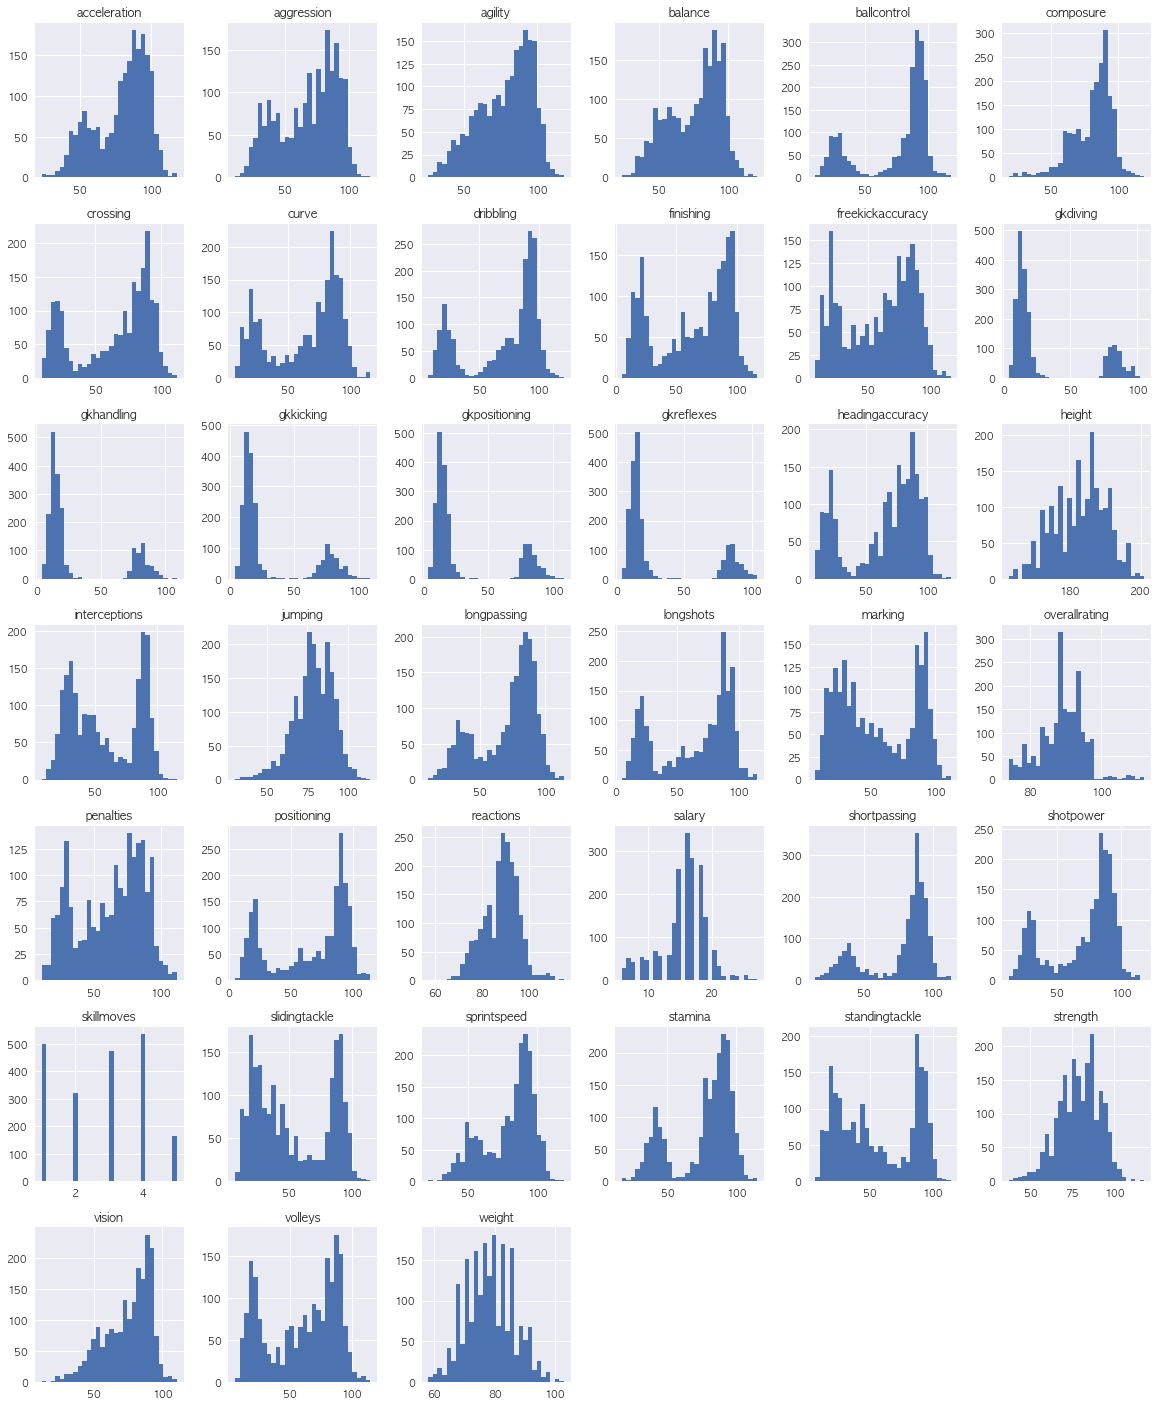

In [179]:
# 몸무게, 키, 급여 의 경우는 x 축의 범위가 다름을 확인 가능
# 데이터 분포가 보통 0~50 과 50~120 에서 각각 한번씩 이루어지는 데, 이는 골키퍼가 골키퍼에 필요한 능력을 제외하고는 50 이히의 수치를 보통 보여주기 때문이라고 생각됨
df_temp = df.drop(['playercode', 'name'], axis=1)
df_temp.hist(bins=30,figsize=(20,25))
plt.show()

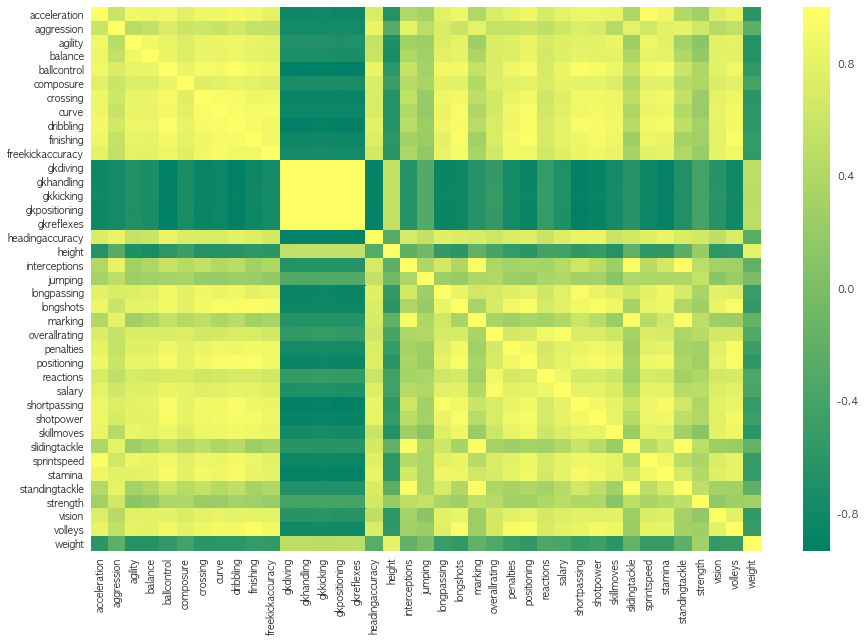

In [180]:
# 모든 변수에 대한 heatmap 그리기
plt.figure(figsize=(15,10))
sns.heatmap(df_temp.corr(), cmap = 'summer')

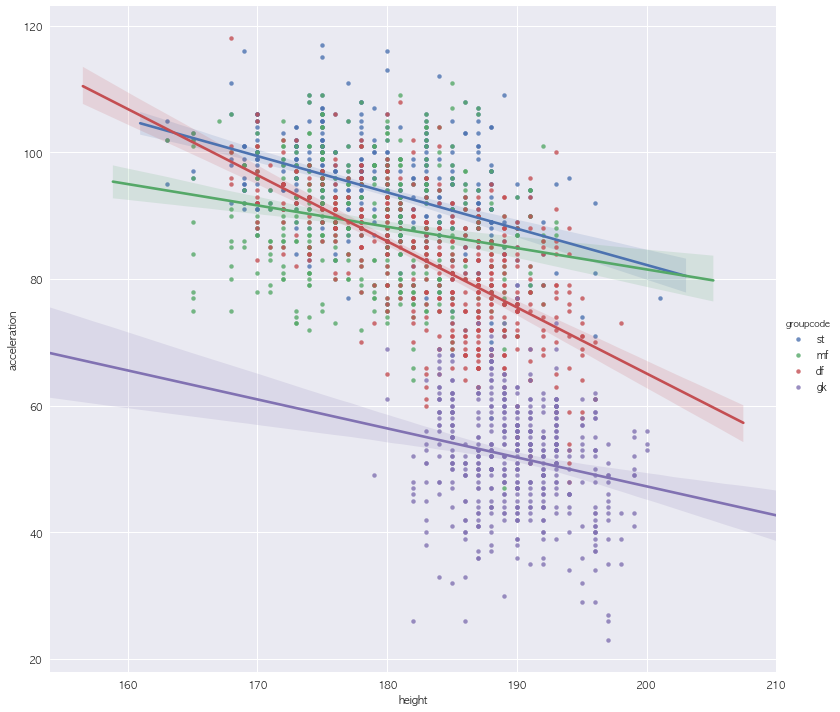

In [181]:
# 속력 과 키 에 대한 포지션별 lmplot 그리기
# 골키퍼 의 경우에는 보통 다른 포지션보다 큰 키와 낮은 속력을 가지고 있음
# 수비수 의 경우 키와 속력의 반비례 관계가 가장 두드러지게 나타남
# 미드필더 의 경우 공격수와 수비수보다 키가 속력에 미치는 반비례 관계가 가장 낮음
sns.lmplot(x='height', y='acceleration', data = df, hue = 'groupcode', height = 10, aspect = 1.1, scatter_kws = {'s' : 20})

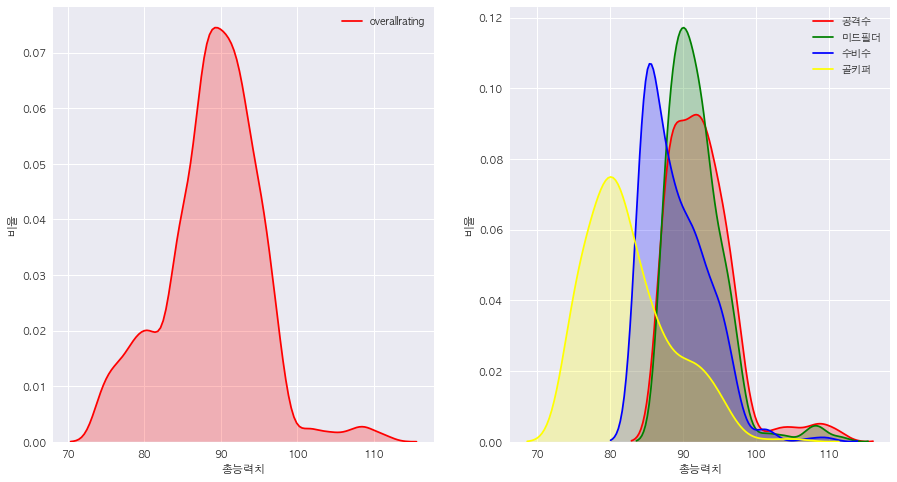

In [182]:
# 총능력치에 대한 포지션별 kdeplot 그리기
# 전체적인 총 능력치는 st > mf > df > gk
# 미드필더의 경우 80후반 부터 90중반까지 많은 비율을 보임
plt.figure(figsize=(15,8))
allovr = plt.subplot(1,2,1)
allovr = sns.kdeplot(df['overallrating'], color = "red",shade= True)
allovr.set_xlabel('총능력치')
allovr.set_ylabel('비율')

ovr = plt.subplot(1,2,2)
ovr = sns.kdeplot(df.query('groupcode == "st"')['overallrating'], color = "red",shade= True)
ovr = sns.kdeplot(df.query('groupcode == "mf"')['overallrating'], color = 'green', shade = True)
ovr = sns.kdeplot(df.query('groupcode == "df"')['overallrating'], color = "blue",shade= True)
ovr = sns.kdeplot(df.query('groupcode == "gk"')['overallrating'], color = 'yellow', shade = True)
ovr.set_xlabel('총능력치')
ovr.set_ylabel('비율')
ovr = ovr.legend(['공격수','미드필더', '수비수', '골키퍼'])

plt.show()

### 2-2. 인코딩 및 데이터 분할

In [183]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

In [184]:
# One-hot 인코딩
dum = pd.get_dummies(df.groupcode, prefix='position')
df = pd.concat([df,dum], axis=1)
df = df.drop('groupcode', axis=1)

In [185]:
df.head()

,acceleration,aggression,agility,balance,ballcontrol,composure,crossing,curve,dribbling,finishing,...,standingtackle,strength,vision,volleys,weight,name,position_df,position_gk,position_mf,position_st
0,113,106,112,110,115,113,105,115,117,112,...,59,96,111,111,71,요한 크루이프,0,0,0,1
1,109,68,113,115,116,108,107,113,116,109,...,54,86,111,103,73,로베르토 바조,0,0,0,1
2,115,95,117,110,108,111,105,104,117,117,...,61,101,105,115,76,에우제비우,0,0,0,1
3,116,97,118,121,111,116,109,105,121,109,...,60,86,104,98,72,가린샤,0,0,0,1
4,109,117,104,112,105,111,92,102,106,117,...,54,118,93,106,88,D. 드로그바,0,0,0,1


In [186]:
# train, test 데이터 분할 (8 : 2)
train, test = train_test_split(df, test_size = 0.2)
train_id = train[['playercode', 'name']]
test_id = test[['playercode', 'name']]
train = train.drop(['playercode', 'name'], axis=1)
test = test.drop(['playercode', 'name'], axis=1)

In [187]:
X_train = train.drop('overallrating', axis = 1)
y_train = train['overallrating']
X_test = test.drop('overallrating', axis = 1)
y_test = test['overallrating']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 42), (400, 42), (1600,), (400,))

In [188]:
# 스케일링 진행
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

# 3. Modeling

In [189]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn import ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import matplotlib.pyplot as plt

### 3-1. Base Model

   - 선형 회귀분석

In [219]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_lm = lm.predict(X_test)

In [220]:
# X_test에 대한 예측된 overallrating 를 확인할 수 있음
y_lm[:10]

array([ 95.0267452 ,  85.80366171,  90.98945272,  78.68903768,
        88.32032431,  88.8300289 ,  87.43763388, 100.06446493,
        90.90974081,  86.89265097])

In [221]:
print("선형회귀분석 train 정확도 : ", lm.score(X_train, y_train))
print("선형회귀분석 test 정확도 : ", lm.score(X_test, y_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_lm)))

선형회귀분석 train 정확도 :  0.9496477748359688
선형회귀분석 test 정확도 :  0.9448944815720932
RMSE: 1.4532384930507822


   - XGBoost

In [193]:
params = { 'max_depth' : 3,
          'learning_rate' : 0.1,
          'n_estimators' : 1000,
          'reg_alpha' : 0.001,
          'reg_lambda' : 0.000001,
          'n_jobs' : -1,
          'min_child_weight' : 3
}

XGB = XGBRegressor(**params)
XGB.fit(X_train,y_train)

[13:54:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.001, reg_lambda=1e-06, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [194]:
y_xgb = XGB.predict(X_test)

In [195]:
print("XGBRegressor train 정확도 :",XGB.score(X_train,y_train))
print("XGBRegressor test 정확도 : ", XGB.score(X_test, y_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_xgb)))

XGBRegressor train 정확도 : 0.9994630450865656
XGBRegressor test 정확도 :  0.9849849442046521
RMSE: 0.7585825037501653


   - Gradient Boosting Regression

In [196]:
params = {'n_estimators': 3000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
GBR = ensemble.GradientBoostingRegressor(**params)
GBR.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [197]:
y_gbr = GBR.predict(X_test)

In [198]:
print("GradientBoostingRegressor train 정확도 :",GBR.score(X_train, y_train))
print("GradientBoostingRegressor test 정확도 :",GBR.score(X_test, y_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_gbr)))

GradientBoostingRegressor train 정확도 : 0.9986370726017622
GradientBoostingRegressor test 정확도 : 0.9837517820401095
RMSE: 0.7891184811522636


   - SVM Regression

In [199]:
params = {'C' : 1, 'cache_size' : 200,
          'coef0' : 0, 'degree' : 3,
          'epsilon' : 0.0, 'gamma' : 'auto',
          'kernel' : 'rbf', 'max_iter' : -1,
          'shrinking' : True, 'tol' : 0.001, 'verbose' : False
         }

svm = SVR(C=1, cache_size=200, coef0=0, degree=3, epsilon=0.0, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svm.fit(X_train, y_train)

SVR(C=1, cache_size=200, coef0=0, degree=3, epsilon=0.0, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [200]:
y_svm = svm.predict(X_test)

In [201]:
print("SVM regression train 정확도 :",svm.score(X_train, y_train))
print("SVM regression test 정확도 :",svm.score(X_test, y_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_svm)))

SVM regression train 정확도 : 0.9629235510070451
SVM regression test 정확도 : 0.9444004651041276
RMSE: 1.4597380407205778


   - 랜덤 포레스트

In [202]:
Rforest = RandomForestRegressor(n_estimators = 1000, random_state = 42)
Rforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [203]:
y_rfo = Rforest.predict(X_test)

In [204]:
print("랜덤포레스트 train 정확도 :",Rforest.score(X_train, y_train))
print("랜덤포레스트 test 정확도 :",Rforest.score(X_test, y_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_rfo)))

랜덤포레스트 train 정확도 : 0.9961536900305435
랜덤포레스트 test 정확도 : 0.9722372489930203
RMSE: 1.0315032379978262


In [205]:
# 각 모델의 RMSE 를 비교
# XGBoost 이 가장 낮은 RMSE를 보이며 다음으로 GBR, 랜덤포레스트 순임 
model_name = np.array(['lm', 'xgb', 'gbr', 'svm', 'rfo'])
error_rate=np.array(
    [np.sqrt(metrics.mean_squared_error(y_test, y_lm)),
     np.sqrt(metrics.mean_squared_error(y_test, y_xgb)),
     np.sqrt(metrics.mean_squared_error(y_test, y_gbr)),
     np.sqrt(metrics.mean_squared_error(y_test, y_svm)),
     np.sqrt(metrics.mean_squared_error(y_test, y_rfo)),
    ])

Text(0, 0.5, 'RMSE')

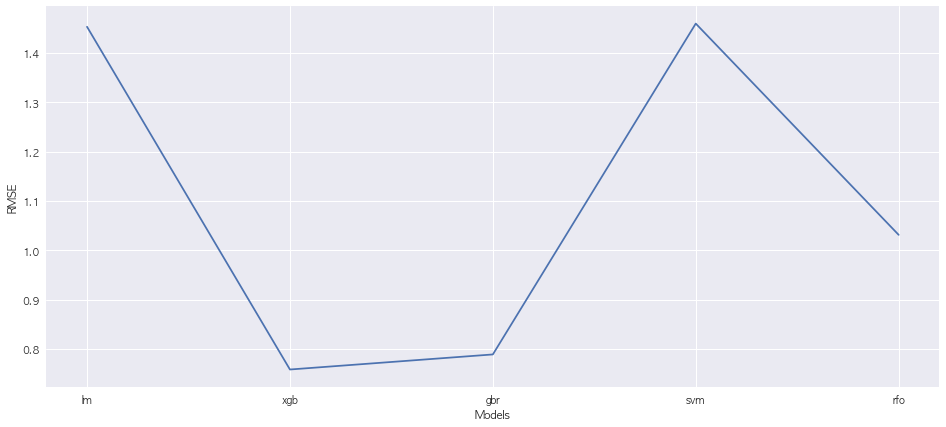

In [206]:
plt.figure(figsize=(16,7))
plt.plot(model_name,error_rate)
plt.xlabel("Models")
plt.ylabel("RMSE")

### 3-2. Ensemble methods

#### Stacking

   - Simplest Stacking approach : Averaging base models

In [207]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [208]:
# Averaged base models class
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [209]:
averaged_models = AveragingModels(models = (XGB, GBR))
averaged_models.fit(X_train, y_train)

[13:55:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


AveragingModels(models=(XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     importance_type='gain', learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=3, missing=None,
                                     n_estimators=1000, n_jobs=-1, nthread=None,
                                     objective='reg:linear', random_state=0,
                                     reg_alpha=0.001, reg_lambda=1e-06,
                                     s...
                                                  init=None, learning_rate=0.01,
                                                  loss='ls', max_depth=4,
                                                  max_features=None,
                                                  max_leaf_nodes=None,

In [210]:
y_avg = averaged_models.predict(X_test)

In [211]:
print("Averaged base models train 정확도 :",averaged_models.score(X_train, y_train))
print("Averaged base models test 정확도 :",averaged_models.score(X_test, y_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_avg)))

Averaged base models train 정확도 : 0.9991677443792475
Averaged base models test 정확도 : 0.985109998367011
RMSE: 0.7554169395249921


In [212]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [213]:
y_ensemble = y_xgb * 0.4 + y_gbr * 0.1 + y_avg * 0.5
rmsle(y_test, y_ensemble)

0.7526085361751892

#### voting regressor

In [214]:
from sklearn.ensemble import VotingRegressor

vote_mod = VotingRegressor([('XGBRegressor', XGB), ('GBR', GBR),
                            ('AveragedModel', averaged_models)])

vote = vote_mod.fit(X_train, y_train)
y_vote = vote.predict(X_test)

[13:55:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [215]:
print("voting regressor train 정확도 :",vote.score(X_train, y_train))
print("voting regressor test 정확도 :",vote.score(X_test, y_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_vote)))

voting regressor train 정확도 : 0.9991677443792475
voting regressor test 정확도 : 0.9851040823113832
RMSE: 0.7555669947406676


In [216]:
y_ensemble = y_xgb * 0.3 + y_gbr * 0.05 + y_avg * 0.3 + y_vote * 0.35
rmsle(y_test, y_ensemble)

0.7528708443784063

# 4. 결과

In [239]:
pred_overall = pd.DataFrame(y_ensemble, columns = ['pred_overallrating'])

test_temp = pd.concat([test_id, y_test], axis = 1)
test_temp = test_temp.reset_index(drop = True)

submission = pd.concat([test_temp, pred_overall], axis = 1)
submission

,playercode,name,overallrating,pred_overallrating
0,217204838,라울 히메네스,97,96.252744
1,216170084,웨인 헤네시,91,89.984995
2,214176635,메수트 외질,91,91.279111
3,217182629,베투,81,79.858723
4,207180206,M. 피아니치,88,88.364503
...,...,...,...,...
395,207000001,데이비드 시먼,86,84.374920
396,216234642,에두아르 멘디,85,85.067668
397,214208722,사디오 마네,91,91.453348
398,207191189,L. 마테우스,92,93.135374


# 5. 포지션 분류하기

GK(골키퍼)를 제외한 나머지 포지션(공격수, 미드필더, 수비수) 사이의 데이터 차이를 확인하고 군집화 진행

In [427]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm

In [322]:
# 불러오기
df = pd.read_excel('DB_player.xlsx')
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,acceleration,aggression,agility,balance,ballcontrol,composure,crossing,curve,dribbling,finishing,...,skillmoves,slidingtackle,sprintspeed,stamina,standingtackle,strength,vision,volleys,weight,name
0,113,106,112,110,115,113,105,115,117,112,...,5,66,107,106,59,96,111,111,71,요한 크루이프
1,109,68,113,115,116,108,107,113,116,109,...,5,52,105,101,54,86,111,103,73,로베르토 바조
2,115,95,117,110,108,111,105,104,117,117,...,4,53,118,108,61,101,105,115,76,에우제비우
3,116,97,118,121,111,116,109,105,121,109,...,5,65,119,105,60,86,104,98,72,가린샤
4,109,117,104,112,105,111,92,102,106,117,...,4,59,106,105,54,118,93,106,88,D. 드로그바


In [323]:
# 포지션별 코드를 숫자로 label 변경
def changePS(x):
    if x == 'st':
        return 0
    elif x == 'mf':
        return 1
    elif x == 'df':
        return 2
    else:
        return 3

In [324]:
df['groupcode'] = df['groupcode'].apply(lambda x: int(changePS(x)))

In [325]:
df['groupcode'].value_counts()

3    500
2    500
1    500
0    500
Name: groupcode, dtype: int64

In [343]:
# 골키퍼는 나머지 세 포지션과 성향이 너무 다름으로 삭제
# pca 돌렸을 때 골키퍼만 따로 노는게 너무 확실하게 보임
df = df[df['groupcode'] != 3]
df['groupcode'].value_counts()

2    500
1    500
0    500
Name: groupcode, dtype: int64

In [344]:
# train, test 데이터 분할 (8 : 2)
train, test = train_test_split(df, test_size = 0.2)
train_id = train[['playercode', 'name']]
test_id = test[['playercode', 'name']]
train = train.drop(['playercode', 'name'], axis=1)
test = test.drop(['playercode', 'name'], axis=1)

In [345]:
X_train = train.drop('groupcode', axis = 1)
y_train = train['groupcode']
X_test = test.drop('groupcode', axis = 1)
y_test = test['groupcode']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 39), (300, 39), (1200,), (300,))

In [346]:
# 스케일링 진행
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

### PCA + Kmeans

In [347]:
# 먼저 3개의 주성분으로 PCA 를 진행
pca = PCA(n_components=3)
pca_train = pca.fit_transform(X_train)
features = range(pca.n_components_) # components_ 개수

pca_df = pd.DataFrame(np.c_[pca_train, y_train], columns = ['factor1', 'factor2', 'factor3', 'label'])

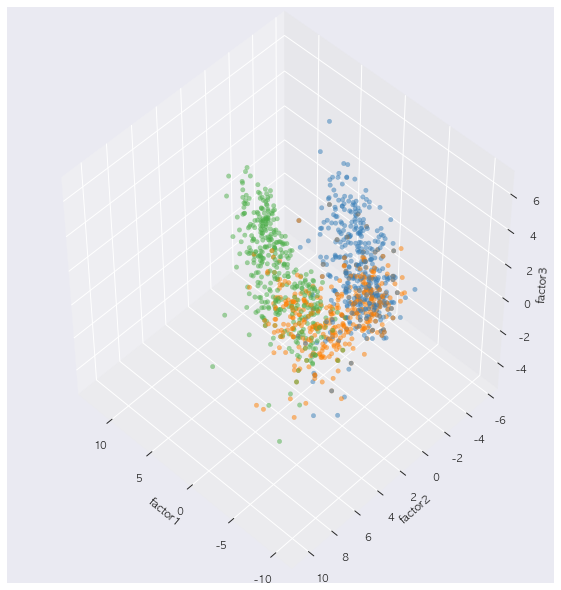

In [348]:
# 3차원
# 약간의 차이가 보이긴함
fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(pca_df['factor1'], pca_df['factor2'], pca_df['factor3'], c=colors[pca_df['label'].astype(int)], alpha=0.5)
ax.set_xlabel('factor1')
ax.set_ylabel('factor2')
ax.set_zlabel('factor3')
plt.show()

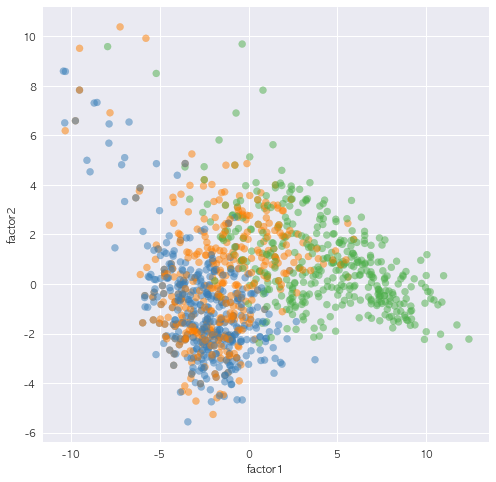

In [349]:
# 2차원
# 3차원 보다는 구분하기 힘듬
pca = PCA(n_components = 2)
pca_train = pca.fit_transform(X_train)
pca_df = pd.DataFrame(np.c_[pca_train, y_train], columns = ['factor1', 'factor2', 'label'])

plt.figure(figsize = (8,8))
plt.scatter(pca_df['factor1'], pca_df['factor2'], c=colors[pca_df['label'].astype(int)], alpha=0.5)
plt.xlabel('factor1')
plt.ylabel('factor2')
plt.show()

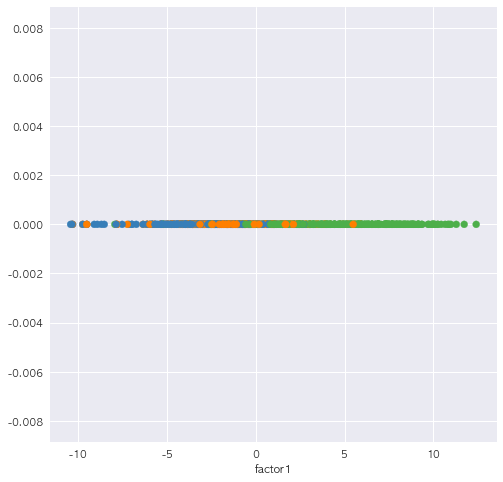

In [350]:
# 1차원
# 2차원 보다는 데이터가 구분되는 것이 보임
pca = PCA(n_components = 1)
pca_train = pca.fit_transform(X_train)
pca_df = pd.DataFrame(np.c_[pca_train, y_train], columns = ['factor1', 'label'])

plt.figure(figsize = (8,8))
plt.scatter(pca_df['factor1'], len(pca_df)*[0], c = colors[pca_df['label'].astype(int)])
plt.xlabel('factor1')
plt.show()

In [428]:
# 전체 feature 로 PCA 를 진행
pca = PCA()
pca_train = pca.fit_transform(X_train)
features = range(pca.n_components_) # components_ 개수

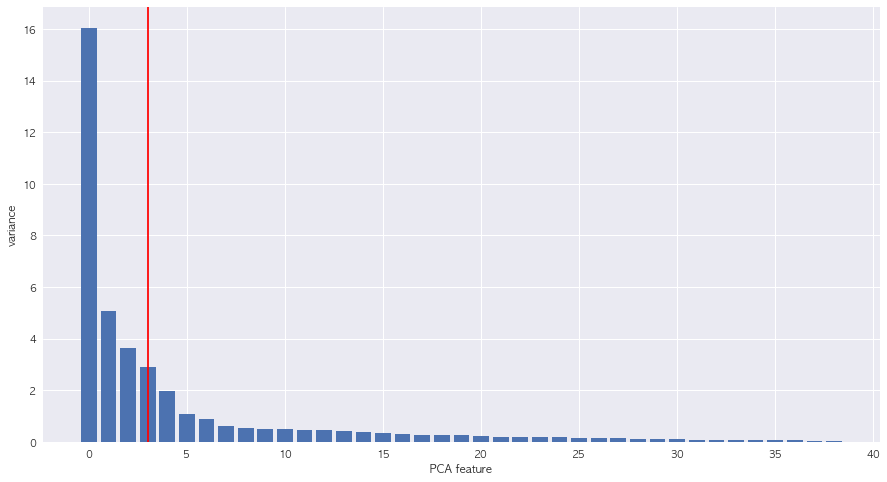

In [429]:
# 주성분이 이루는 축에 따른 분산의 비율 분포
# 3번 째 이하의 주성분 축이 그 이후의 주성분 축에 비해 많은 양을 가지고 있음
# 특히 1번 째 주성분 축쯤에서 급격히 감소함
plt.figure(figsize=(15,8))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.axvline(x=3, c='r')
plt.show()

In [430]:
# 첫번째 주성분이 40% 이상의 정보를 가지고 있음
pca.explained_variance_ratio_

array([0.4113452 , 0.12970829, 0.09336198, 0.07417034, 0.05042413,
       0.02779469, 0.02229113, 0.01543965, 0.01412528, 0.01277756,
       0.01222517, 0.01215429, 0.01124734, 0.01034546, 0.00994411,
       0.00890395, 0.00791356, 0.00705175, 0.00686255, 0.00626473,
       0.0053779 , 0.00478063, 0.00466778, 0.00438421, 0.00430474,
       0.00374755, 0.00353712, 0.0033919 , 0.00322698, 0.002775  ,
       0.00250709, 0.002266  , 0.00202072, 0.00194817, 0.00175773,
       0.00158406, 0.00140271, 0.0011813 , 0.00078724])

In [400]:
# 적절한 차원 선택하기
# 누적된 분산의 비율(누적설명률)을 기준으로 주성분 개수 결정
# 15 까지의 주성분이 전체 데이터의 90%의 설명력을 보임
cumsum = np.cumsum(pca.explained_variance_ratio_)
k = np.argmax(cumsum >= 0.9) + 1
print('선택할 차원 수 :', k)

선택할 차원 수 : 15


In [439]:
# 주성분 15 로 PCA 를 진행
pca = PCA(n_components = 15)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

In [440]:
# 90% 이상을 설명하는 pca_train 으로 kmeans의 데이터로 사용
kmeans = KMeans(n_clusters = 3)
k_train = kmeans.fit_predict(pca_train)
k_test = kmeans.predict(pca_test)

groupcode    0    1    2
row_0                   
0          393  202    0
1            9  193  170
2            2    9  222 

groupcode   0   1   2
row_0                
0          92  47   1
1           4  45  39
2           0   4  68


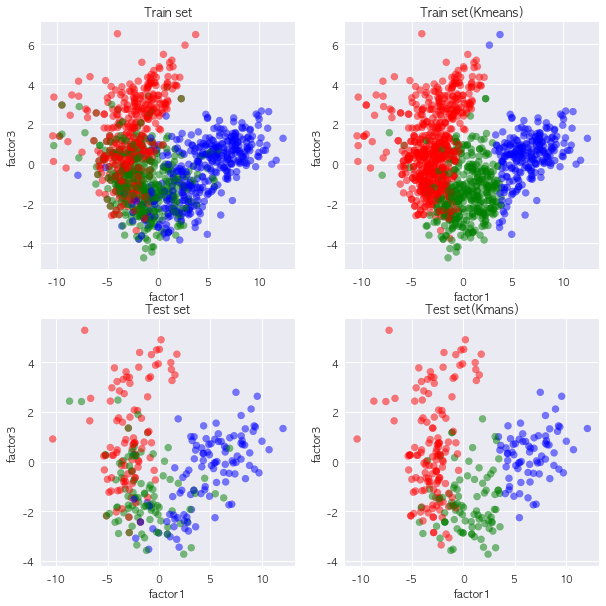

In [468]:
# 해당 선수의 본래 포지션과 PCA와 Kmeans로 예측한 포지션은 다음과 같음
# 공격수의 경우에는 미드필더와 수비수와는 다르게 공격수로 대부분 분류됨
# 미드필더의 경우 보통 공격수와 수비수가 가지고 있는 능력치를 고르게 가지고 있는데 공격수로 많이 분류된 것을 볼 수 있음, 수비수로는 거의 분류되지 않음
# 수비수의 경우에도 공격수로는 거의 분류되지 않았고 미드필더로도 많이 분류됨

colors = {0:'r', 1: 'g', 2: 'b'}
train_label = [colors[i] for i in k_train] # train 예측 군집
test_label = [colors[i] for i in k_test] # test 예측 군집
r_label = [colors[i] for i in y_train]
s_label = [colors[i] for i in y_test]

result1 = pd.crosstab(k_train, y_train)
result2 = pd.crosstab(k_test, y_test)
print(result1,'\n')
print(result2)

# plot 그리기
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(221)
plt.scatter(pca_train[:,0],pca_train[:,2], c= r_label, alpha=0.5)
plt.xlabel('factor1')
plt.ylabel('factor3')
plt.title('Train set')

ax = fig.add_subplot(222)
plt.scatter(pca_train[:,0],pca_train[:,2], c= train_label, alpha=0.5)
plt.xlabel('factor1')
plt.ylabel('factor3')
plt.title('Train set(Kmeans)')


ax = fig.add_subplot(223)
plt.scatter(pca_test[:,0],pca_test[:,2], c= s_label, alpha=0.5)
plt.xlabel('factor1')
plt.ylabel('factor3')
plt.title('Test set')

ax = fig.add_subplot(224)
plt.scatter(pca_test[:,0],pca_test[:,2], c= test_label, alpha=0.5)
plt.xlabel('factor1')
plt.ylabel('factor3')
plt.title('Test set(Kmans)')

plt.show()



### 계층적 군집화(Hierarchical Clustering)

In [471]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

In [389]:
X_train = pd.DataFrame(X_train)

In [411]:
# method 에는 적용하고 싶은 거리 계산 방법
mergings = linkage(X_train, method='ward')

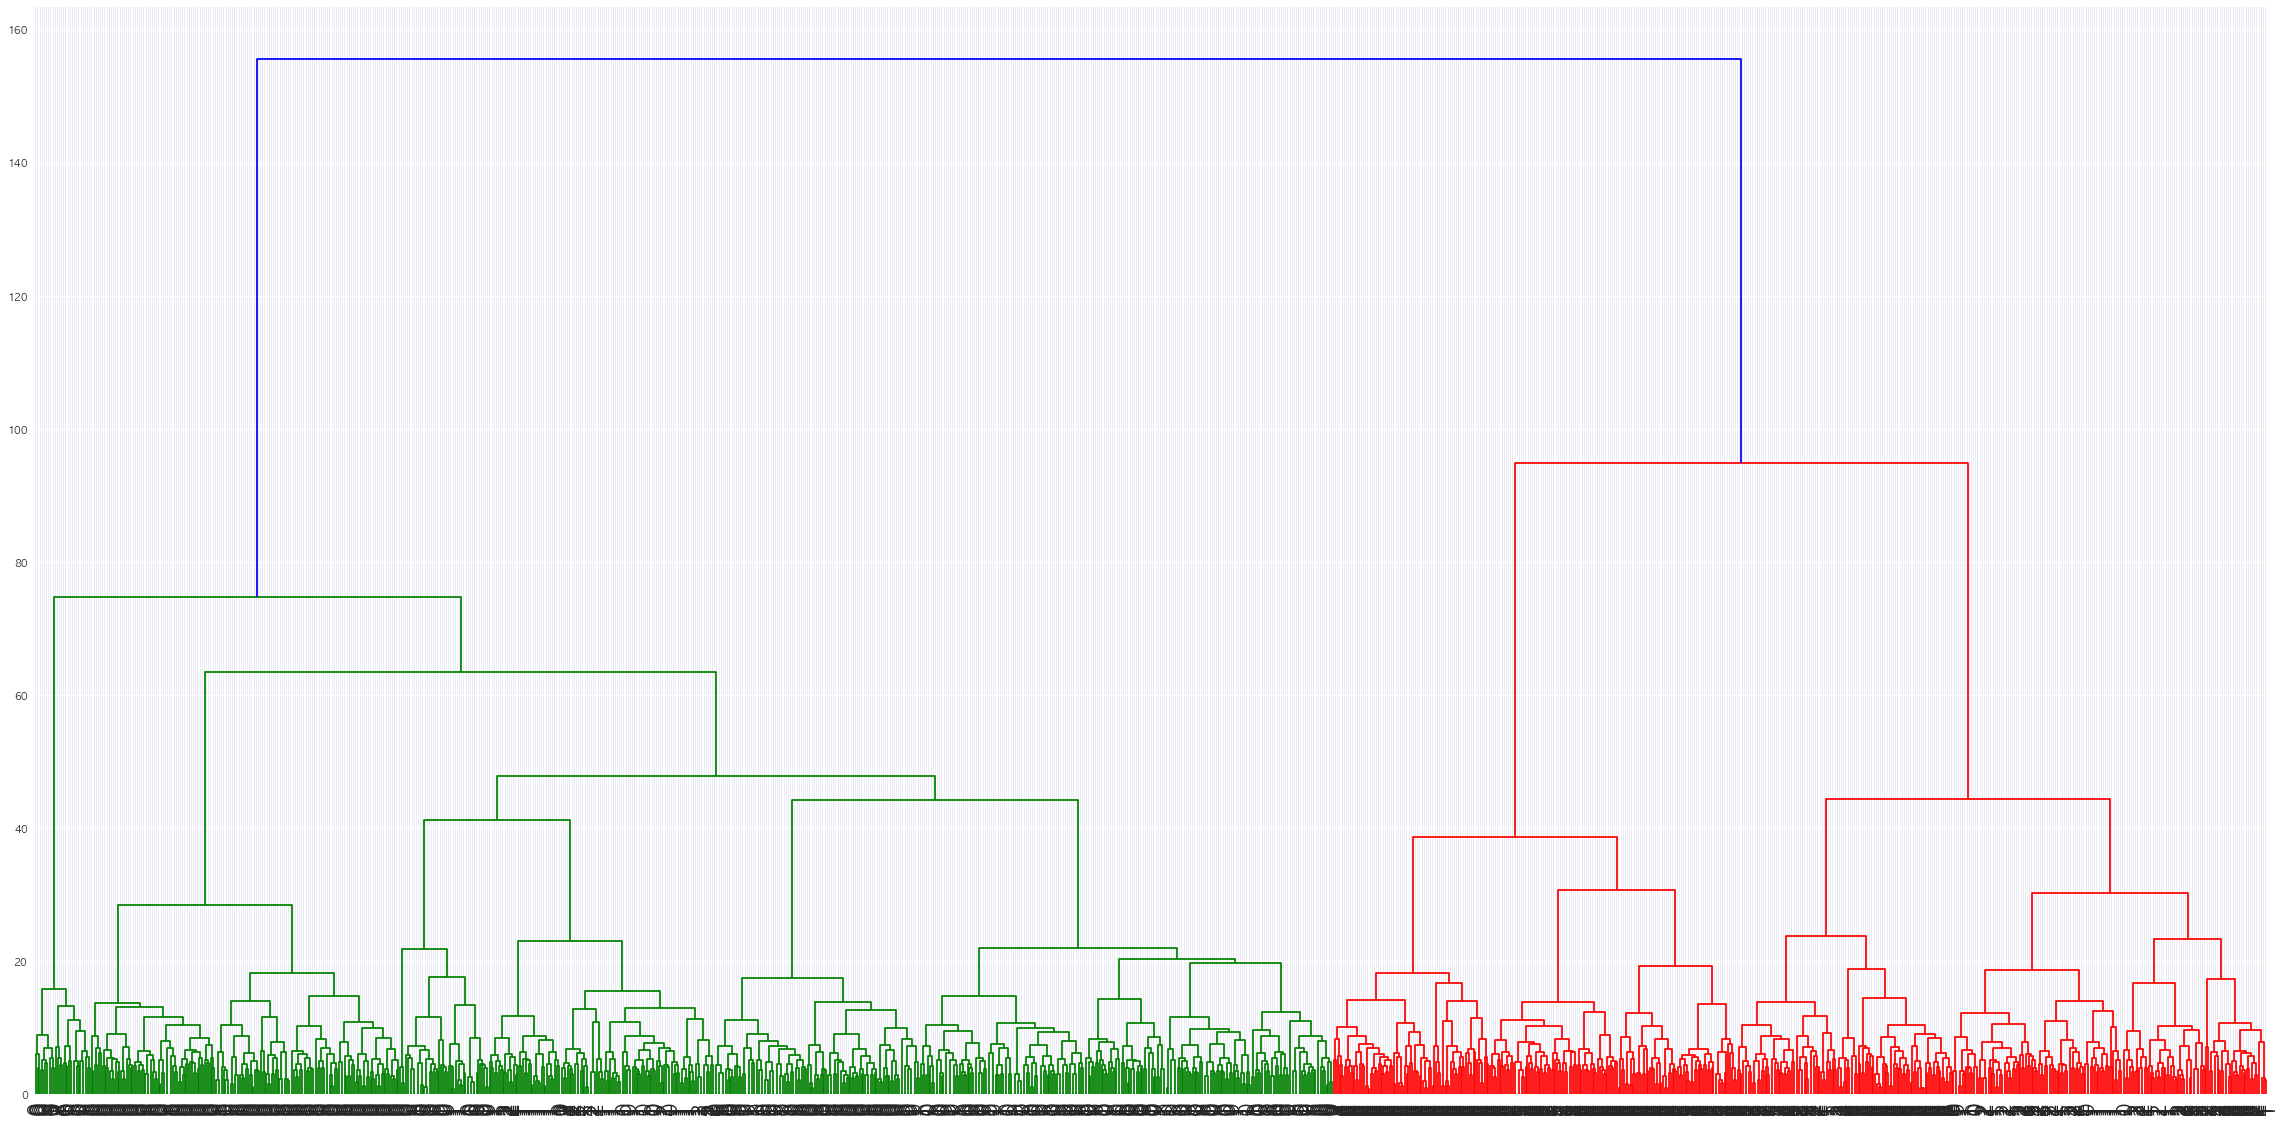

In [412]:
# centroid 거리계산을 사용했을 때 2개의 군집으로 나누어지는 것을 확인 가능
plt.figure(figsize=(40,20))
dendrogram(mergings,
           labels = y_train.as_matrix(),
           leaf_rotation=90,
           leaf_font_size=20,
)
plt.show()

In [475]:
# 거리 60일 때 기준으로 나누게 되면 군집이 4개까지 나뉘어짐
predict = pd.DataFrame(fcluster(mergings, 60, criterion='distance'))
predict.columns=['predict']
result = pd.crosstab(predict['predict'], y_train)
print(result)

groupcode    0    1    2
predict                 
1            0    7  205
2           10  176  184
3           18    9    2
4          376  212    1


In [507]:
h_df = pd.concat([train_id.reset_index(drop = True), predict, y_train], axis = 1)
h_df.head()

,playercode,name,predict,groupcode
0,502172871,얀 베르통언,1,2
1,215189513,파레호,2,1
2,216168542,다비드 실바,4,1
3,297204884,뱅자맹 멘디,2,2
4,207000570,J. 오코차,4,1


In [516]:
# 1 군집은 수비수가 많이 분류된 것으로 보아 수비수가 보통 있을 것으로 판단됨
# 미드필더가 1 군집으로 분류된 선수를 보면 거의 수비수임을 알 수 있음
h_df.loc[(h_df['predict'] == 1) & (h_df['groupcode'] == 1), 'name']

292       에릭 다이어
430      데클런 라이스
545     A. 크리스텐센
554      리오 퍼디난드
614       마츠 후멜스
793      마르셀 드사이
1190     오리올 로메우
Name: name, dtype: object

In [519]:
# 2 군집은 미드필더와 수비수가 많이 속해있는 것으로 보아 수비형 미드필더 거나 공격적인 수비수라고 예상됨
# 예상대로 미드필더의 경우에는 수비형 미드필더가 많았고 수비수의 경우에는 풀백이나 윙백의 경우가 많았음
h_df.loc[(h_df['predict'] == 2), 'name']

1             파레호
3          뱅자맹 멘디
6             파비뉴
7        G. 보나벤투라
10         프렝키 더용
          ...    
1183    세스크 파브레가스
1185    세르지오 부스케츠
1187          파비뉴
1191      알렉스 산드루
1194      유리 틸레만스
Name: name, Length: 370, dtype: object

In [520]:
# 3 군집은 세 포지션이 모두 적게 분포되어 있음
# 다음 선수들이 어떤 공통점을 가지고 있는지는 잘 모르겠으나, 전설의 선수이기에 일단 능력치가 매우 높고, 전체적인 능력치가 고르게 분포되어있는 것으로 추측됨
h_df.loc[h_df['predict'] == 3, 'name']

73        A. 델피에로
76        잔프랑코 졸라
77         이언 라이트
115        O. 솔샤르
149     호베르투 카를루스
150        게리 리네커
202         이언 러시
223       요한 크루이프
364         에우제비우
365       파울루 푸트리
524       에마뉘엘 프티
561       로베르토 바조
621      B. 라우드루프
719            라울
722        로비 파울러
767       D. 베르캄프
791        테디 셰링엄
876       A. 델피에로
934         소크라테스
949        지네딘 지단
980       O. 비어호프
990       G. 잠브로타
999           가린샤
1001         히바우두
1025       O. 솔샤르
1049      스티븐 제라드
1059         히바우두
1143      C. 발데라마
1150      H. 크레스포
Name: name, dtype: object

In [522]:
# 4 군집에서는 공격수와 미드필더가 다수 포함되어 있는 것으로 보아 공격수 혹은 공격 미드필더가 포함되어있는 것으로 예상됨
h_df.loc[(h_df['predict'] == 4) & (h_df['groupcode'] == 1), 'name']

2         다비드 실바
4         J. 오코차
5           카날레스
13           손흥민
19      파블로 사라비아
          ...   
1188     제르단 샤키리
1192     루카 모드리치
1196         황희찬
1197    더글라스 코스타
1199      주앙 펠릭스
Name: name, Length: 212, dtype: object